# Table of Contents
1. [Table of Contents](#Table-of-Contents)<br>
2. [Utilities and library imports](#Utilities-and-library-imports)<br>
3. [Exploratory analysis](#Exploratory-analysis)<br>
3.0.1 [Column descriptions](#Column-descriptions)<br>
3.0.2 [Sample values](#Sample-values)<br>
3.0.3 [Nullness](#Nullness)<br>
3.0.4 [Correlation](#Correlation)<br>
3.0.5 [Analyzing `price`](#Analyzing-price)<br>
3.0.6 [Analyzing features](#Analyzing-features)
4. [Machine learning](#Machine-learning)<br>
4.1 [Data preparation](#Data-preparation)<br>
4.2 [Price prediction](#Price-prediction)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.2.1 [Treating it as a regression problem](#Treating-it-as-a-regression-problem)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.2.2 [Treating it as a classification problem](#Treating-it-as-a-classification-problem)<br>
4.3 [Predicting `guests_included`](#Predicting-guests_included)<br>
4.4 [Predicting `extra_people`](#Predicting-extra_people)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.4.1 [Binary classification approach](#Binary-classification-approach)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.4.2 [Multi-class classification approach](#Multi-class-classification-approach)<br>
5. [Future work](#Future-work)<br>
6. [References](#References)

<hr>

# Utilities and library imports

[back to top](#Table-of-Contents)

In [ ]:
import os
import xgboost
import datetime
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
from gc import collect
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier as LGBMC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit as SSS
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

PERCENTILES = [0.05, 0.1, 0.25, .5, .75, .8, .85, .9, .95, .99, .999]

def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
        https://www.kaggle.com/wiki/MultiClassLogLoss
    idea from this post:
    http://www.kaggle.com/c/emc-data-science/forums/t/2149/is-anyone-noticing-difference-betwen-validation-and-leaderboard-error/12209#post12209

    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

pd.set_option("display.max_colwidth", 100)
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["axes.titlesize"] = 17.
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.

<hr>

# Exploratory analysis

[back to top](#Table-of-Contents)

#### Note
To get the data, download the file _listings.csv.gz_ for any city from the website [Inside Airbnb](http://insideairbnb.com/get-the-data.html).

In [3]:
train = pd.read_csv("train.csv", index_col=0)
train.reset_index(inplace=True)
train.drop("0", 1, inplace=True)

In [4]:
train.loc[:, "price"] = train.price.str.lstrip("$").str.replace(",", "").astype("float")
train.loc[:, "city"] = train.city.str.strip().str.lower()

train.loc[~train.host_acceptance_rate.isnull(), "host_acceptance_rate"] = train[
    ~train.host_acceptance_rate.isnull()].host_acceptance_rate.str.rstrip("%")
train.loc[:, "host_acceptance_rate"] = train.host_acceptance_rate.astype(float)

train.loc[:, "security_deposit"] = train.security_deposit.str.lstrip("$").str.replace(",", "").astype(float)
train.loc[:, "host_response_rate"] = train.host_response_rate.str.rstrip("%").astype(float)
train.loc[:, "extra_people"] = train.extra_people.str.lstrip("$").astype(float)

### Column descriptions

[back to top](#Table-of-Contents)

In [5]:
pd.DataFrame({
    "Column name": train.columns.tolist(),
    "": pd.read_csv("descriptions.csv")["Description"]
}).set_index("Column name").style.set_properties(**{"text-align": "left", "header-align": "left"})

,
Column name,
host_since,Host/property owner's date of Joining
host_response_time,Average time taken by host to respond to queries by guests
host_response_rate,Average % of guest queries responded to by host
host_acceptance_rate,Average % of booking accepted by host
host_is_superhost,Better rated hosts are superhosts
host_total_listings_count,Number of properties listed by the host
host_verifications,What details for the host are available for verifications
host_has_profile_pic,Posted a profile picture
host_identity_verified,Has the host identity been verified


In [6]:
train.loc[:, "logprice"] = train.price.apply(np.log10)
train.loc[:, "hsince"] = train.host_since.str.slice(0, 4)
train.loc[:, "hsince"] = train.hsince.fillna(2012).astype(int)
train.drop("state", 1, inplace=True)

### Sample values
[back to top](#Table-of-Contents)

Let's take a look at some sample values column-wise.

In [7]:
pd.DataFrame(train.apply(lambda x: " | ".join((((
    "\\" if str(_).startswith("$") else "") + str(_)) for _ in x.dropna().unique()[:5])), axis="index"))

,0
host_since,2011-03-09 | 2013-11-17 | 2012-12-06 | 2014-01-10 | 2013-05-14
host_response_time,within an hour | a few days or more | within a few hours | within a day
host_response_rate,98.0 | 100.0 | 94.0 | 20.0 | 92.0
host_acceptance_rate,100.0 | 33.0 | 0.0 | 54.0 | 86.0
host_is_superhost,f | t
host_total_listings_count,1.0 | 7.0 | 3.0 | 9.0 | 2.0
host_verifications,"['email', 'phone', 'facebook', 'reviews', 'kba'] | ['email', 'phone', 'facebook', 'reviews', 'ju..."
host_has_profile_pic,t | f
host_identity_verified,t | f
street,"Brooklyn, NY 11201, United States | Martense Street, Brooklyn, NY 11226, United States | Beach 2..."


**At first glance, it appears to be a hotel/home rental service data describing various properties available for rent and their attributes such as facilities/amenities, availability, reviews, neighborhood, and so on.**

### Nullness
[back to top](#Table-of-Contents)

Next, we check the nullness of existing columns.

In [8]:
(train.isnull().sum().sort_values(ascending=False) / train.shape[0]).where(lambda x: x>0).dropna()

square_feet                    0.981767
security_deposit               0.549333
cleaning_fee                   0.321867
host_acceptance_rate           0.271033
review_scores_accuracy         0.270267
review_scores_checkin          0.270200
review_scores_value            0.269900
review_scores_location         0.269900
review_scores_cleanliness      0.269033
review_scores_communication    0.268667
review_scores_rating           0.266933
reviews_per_month              0.247967
host_response_time             0.224233
host_response_rate             0.224233
market                         0.022700
zipcode                        0.007900
bathrooms                      0.006067
bedrooms                       0.001800
beds                           0.001633
city                           0.001333
host_since                     0.000100
host_identity_verified         0.000100
host_has_profile_pic           0.000100
host_total_listings_count      0.000100
host_is_superhost              0.000100


The data seems well-populated overall. However, it is a counter-intuitive to see that `square_feet` is the column with the most null values (>98% null).

### Correlation
[back to top](#Table-of-Contents)

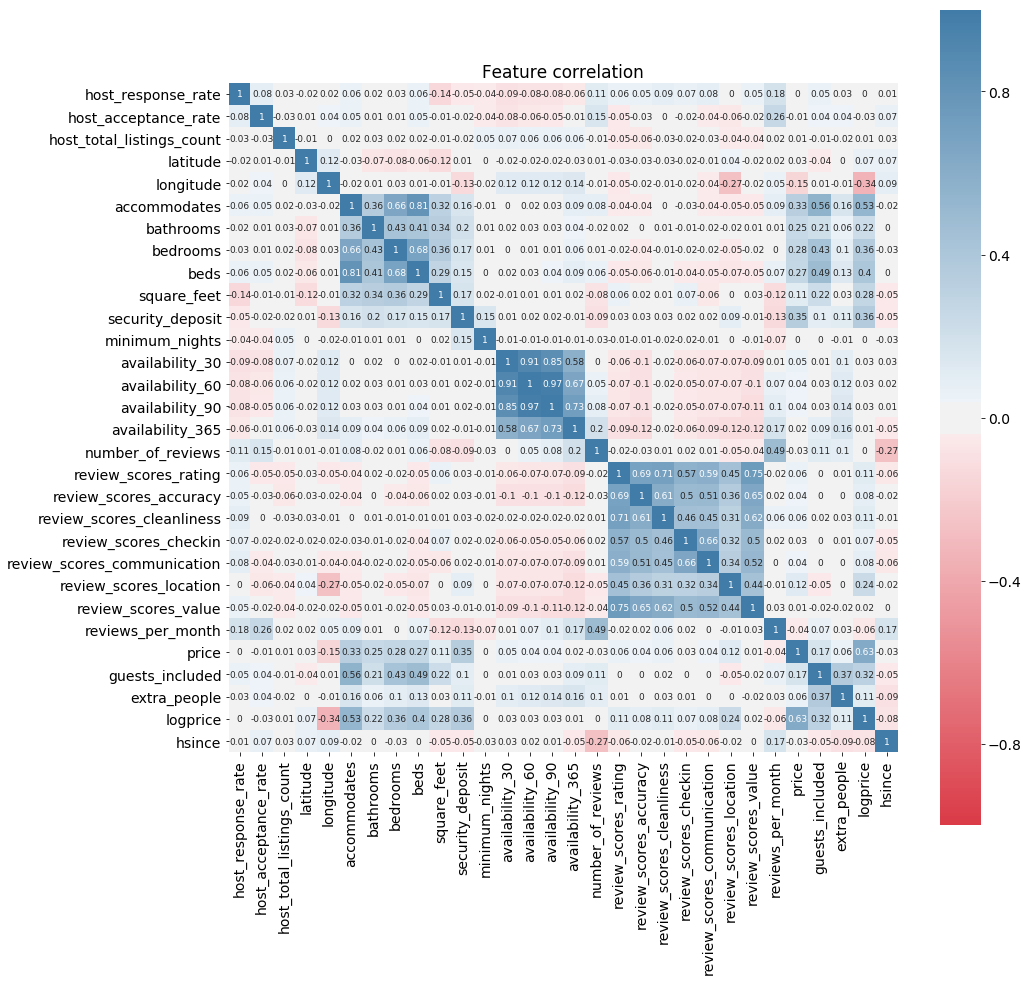

In [14]:
plt.figure(figsize=(15, 15))
_ = sns.heatmap(train.corr().round(2), square=True, vmax=1, vmin=-1, annot_kws={"fontsize": 9.}, cmap=sns.diverging_palette(10, 240, n=150, as_cmap=True), annot=True, )
_ =  _.set_title("Feature correlation")

There is a high correlation between `beds` and `accommodates`, which makes intuitive sense. Also, the review related features are correlated with each other.

There is an extremely high correlation between `availability_60` and `availability_90`. We could remove one of those or combine them into one feature. We remove `availability_60`.

In [15]:
train.drop("availability_60", 1, inplace=True)

### Analyzing `price`
[back to top](#Table-of-Contents)

We see the distribution of `price` which is one of the things to be predicted.

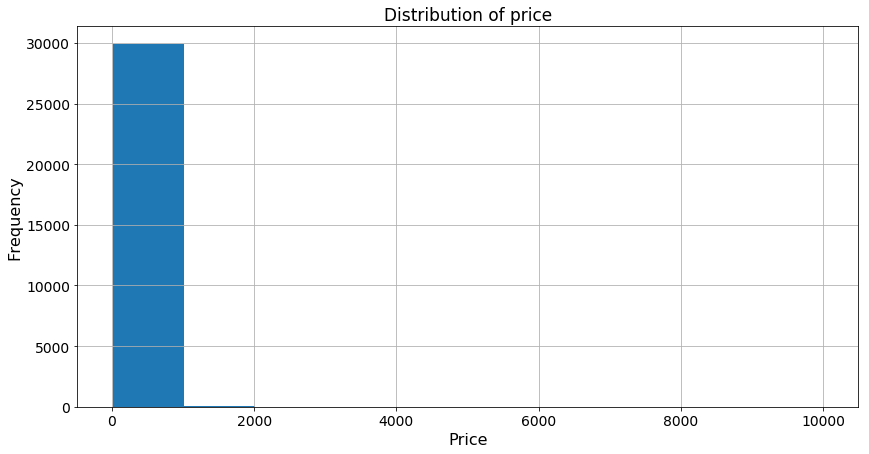

In [16]:
_ = train.price.hist().set(title="Distribution of price", xlabel="Price", ylabel="Frequency")

We take the $log$ of the `price` to make it more suitable for machine learning models and for visualizing.

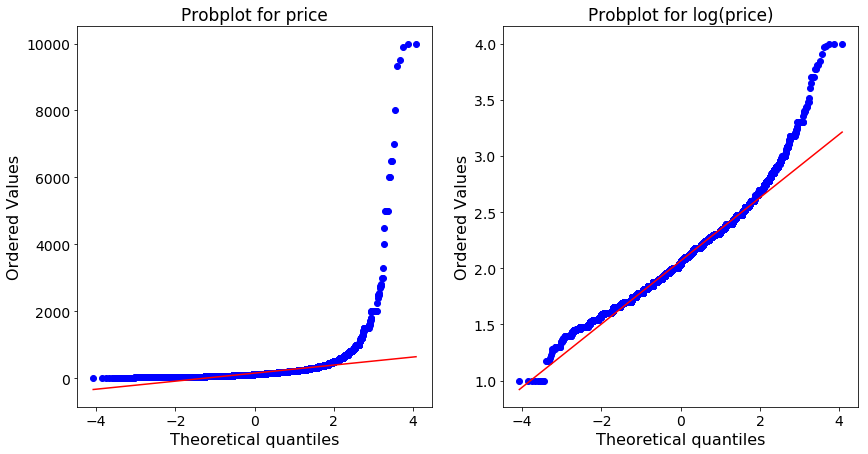

In [17]:
f, axes = plt.subplots(1, 2)
_ = stats.probplot(train.price, dist="norm", plot=axes[0]), axes[0].set_title("Probplot for price")
_ = stats.probplot(train.logprice, dist="norm", plot=axes[1]), axes[1].set_title("Probplot for log(price)")

A QQ-plot indicates how closely a distribution matches a normal distribution. As shown above, after applying $log$ to the price, we see it gets closer to a normal distribution.

In [18]:
train.price.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,30000.0,151.296633,221.417006,10.0,75.0,110.0,179.0,10000.0


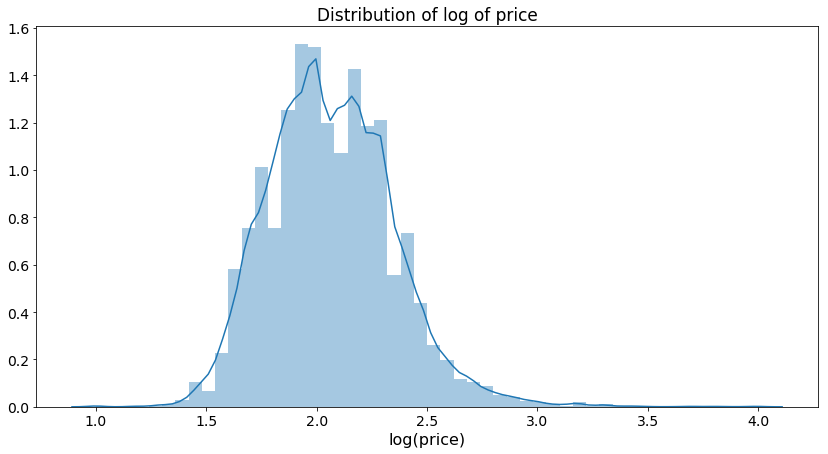

In [20]:
_ = sns.distplot(train["logprice"],)
_ = _.set(title="Distribution of log of price", xlabel="log(price)")

### Analyzing features
[back to top](#Table-of-Contents)

We now analyze various features affecting price.

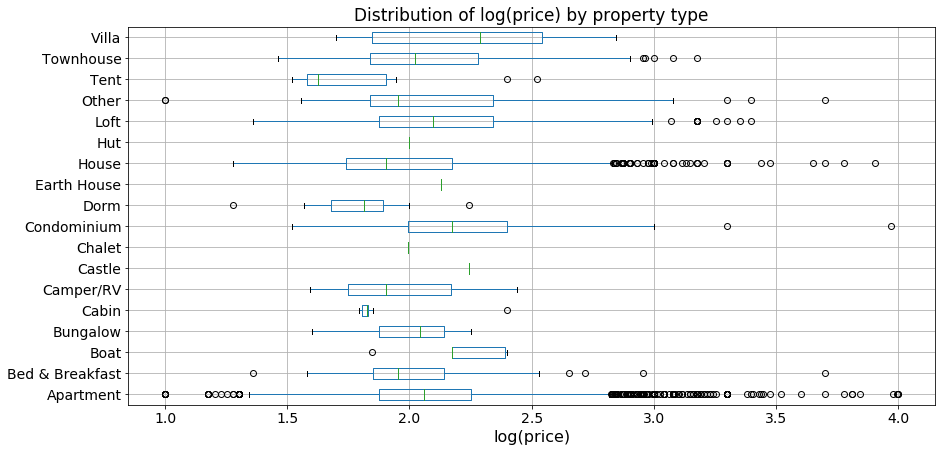

In [21]:
ax = train.boxplot("logprice", "property_type", vert=False)
_ = ax.set(title="Distribution of log(price) by property type", xlabel="log(price)"), plt.suptitle("")

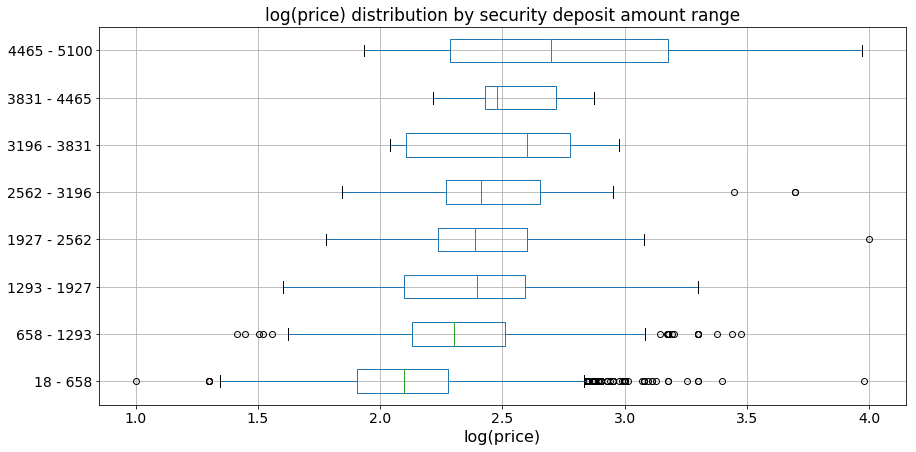

In [22]:
ax = train.assign(secdep=lambda x: pd.cut(x.security_deposit, 8).apply(
    lambda y: "%d - %d" %(y.left, y.right))).boxplot("logprice", "secdep", vert=False)
_ = ax.set(title="log(price) distribution by security deposit amount range", xlabel="log(price)"), plt.suptitle("")

Since `neighbourhood_group_cleansed` is densely populated and has zero null values, we can be confident that all records are accounted for when we group by `neighbourhood_group_cleansed`.

In [23]:
train.groupby("neighbourhood_group_cleansed").price.apply(lambda x: x.describe(percentiles=PERCENTILES)).to_frame().unstack()\
.rename(columns={"price": "Price Distribution"})

Price Distribution                                \
                                          count        mean         std   min   
neighbourhood_group_cleansed                                                    
Bronx                                     406.0   83.273399   60.080782  20.0   
Brooklyn                                12020.0  124.317471  198.605569  10.0   
Manhattan                               14914.0  183.442001  242.436360  10.0   
Queens                                   2498.0  102.406725  179.718115  16.0   
Staten Island                             162.0  118.074074  190.112767  22.0   

                                                                              \
                                 5%   10%    25%    50%    75%    80%    85%   
neighbourhood_group_cleansed                                                   
Bronx                         33.00  38.5  49.25   65.0   99.0  107.0  125.0   
Brooklyn                      40.00  49.0  65.00   95.0  150.0  160.0  180.0   
Manhattan                     55.00  69.0  95.00  145.0  200.0  230.0  250.0   
Queens                        39.00  45.0  55.00   79.0  115.0  125.0  145.0   
Staten Island                 34.05  37.0  50.00   76.5  110.0  120.0  129.0   

                                                                       
                                90%    95%      99%    99.9%      max  
neighbourhood_group_cleansed                                           
Bronx                         150.0  195.0   297.50   586.85    680.0  
Brooklyn                      200.0  269.0   500.00  2000.00   9500.0  
Manhattan                     300.0  400.0   822.92  2408.70  10000.0  
Queens                        170.0  215.0   395.00  1351.50   6500.0  
Staten Island                 178.6  250.0  1195.00  1500.00   1500.0

From the above table, we can see that Manhattan has the most expensive place at \\$10,000 followed by Brooklyn with a place at \\$9,500. Also, Manhattan tends to be generally more expensive than the other neighborhoods.

<hr>

# Machine learning
## Data preparation
[back to top](#Table-of-Contents)

In [24]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("predict.csv", index_col=0)

In [25]:
train.reset_index(inplace=True)
train.drop("0", 1, inplace=True)

In [26]:
train.loc[:, "price"] = train.price.str.lstrip("$").str.replace(",", "").astype("float")
train.loc[:, "logprice"] = train.price.apply(np.log10)

In [27]:
train.loc[train.zipcode.fillna(0).apply(lambda x: any((not x.isdigit() for x in str(x)))), "zipcode"] = "unknown"
test.loc[test.zipcode.fillna(0).apply(lambda x: any((not x.isdigit() for x in str(x)))), "zipcode"] = "unknown"

In [28]:
zle = LabelEncoder().fit(list(set(test.zipcode.fillna("unknown").values).union(train.zipcode.fillna("unknown").values)))
train.loc[:, "zipcode"] = zle.transform(train.zipcode.fillna("unknown"))
test.loc[:, "zipcode"] = zle.transform(test.zipcode.fillna("unknown"))

In [29]:
train.loc[:, "hsince"] = train.host_since.str.slice(0, 4)
test.loc[:, "hsince"] = test.host_since.str.slice(0, 4)

train.loc[:, "city"] = train.city.str.strip().str.lower()
test.loc[:, "city"] = test.city.str.strip().str.lower()

train.loc[:, "hsince"] = train.hsince.fillna(2012).astype(int)
test.loc[:, "hsince"] = test.hsince.fillna(2012).astype(int)

In [30]:
train.loc[~train.host_acceptance_rate.isnull(), "host_acceptance_rate"] = train[
    ~train.host_acceptance_rate.isnull()].host_acceptance_rate.str.rstrip("%")
train.loc[:, "host_acceptance_rate"] = train.host_acceptance_rate.astype(float)

test.loc[~test.host_acceptance_rate.isnull(), "host_acceptance_rate"] = test[
    ~test.host_acceptance_rate.isnull()].host_acceptance_rate.str.rstrip("%")
test.loc[:, "host_acceptance_rate"] = test.host_acceptance_rate.astype(float)

In [31]:
# Same value throughout
train.drop("state", 1, inplace=True)
test.drop("state", 1, inplace=True)
train.drop("availability_60", 1, inplace=True)
test.drop("availability_60", 1, inplace=True)

In [32]:
# Extra people cost
train.loc[:, "extra_people"] = train.extra_people.str.lstrip("$").astype(float)

In [33]:
train.loc[:, "security_deposit"] = train.security_deposit.str.lstrip("$").str.replace(",", "").astype(float)
test.loc[:, "security_deposit"] = test.security_deposit.str.lstrip("$").str.replace(",", "").astype(float)

In [115]:
# Using mean or median imputation doesn't seem to do much better than just using 0
# train.loc[train.security_deposit.isnull(), "security_deposit"] = train.security_deposit.mean()

For certain categorical attributes, we perform dummification to obtain binary features corresponding to each of the levels in the given category.

In [34]:
cols = ["neighbourhood_group_cleansed", "cancellation_policy", "property_type",
        "host_response_time", "room_type", "neighbourhood_cleansed"]
train = pd.get_dummies(train, prefix=["ngc", "cnp", "prt", "hrt", "rmt", "nc"], dummy_na=True, columns=cols)
test = pd.get_dummies(test, prefix=["ngc", "cnp", "prt", "hrt", "rmt", "nc"], dummy_na=True, columns=cols)

In [35]:
price = train.pop("price")
logprice = train.pop("logprice")
extra_people = train.pop("extra_people")
guests_included = train.pop("guests_included")

In [36]:
def process_amenities(f):
    allams = []
    for val in f.amenities.apply(lambda x: set(x.lstrip("{").rstrip("}").split(","))).values:
        for v in val:        
            if v.strip('"').strip() != "":
                allams.append(v.strip('"').strip())
    allams = set(allams)

    def amenitify(row):
        row = [v.strip('"').strip() for v in row]
        k = {("amenity_" + k): k in row for k in allams}
        k["amenity_count"] = len(row)
        return k

    f = pd.concat((f, pd.DataFrame.from_records(f.amenities.apply(lambda x: set(x.lstrip("{").rstrip("}").split(",")))\
    .apply(amenitify).tolist(), index=f.index)), axis=1)
    return f

In [37]:
train = process_amenities(train)
train.drop("amenities", 1, inplace=True)
test = process_amenities(test)
test.drop("amenities", 1, inplace=True)

In [38]:
def process_host_verifications(f):
    allams = []
    for val in f.host_verifications.apply(lambda x: eval(x) if isinstance(eval(x), list) else []):
        for v in val:        
            if v.strip('"').strip() != "":
                allams.append(v.strip('"').strip())
    allams = set(allams)

    def amenitify(row):
        row = [v.strip('"').strip() for v in row]
        k = {("hvc_" + k): k in row for k in allams}
        k["hvc_count"] = len(row)
        return k

    f = pd.concat((f, pd.DataFrame.from_records(f.host_verifications.apply(lambda x: eval(x) if isinstance(eval(x), list) else [])\
    .apply(amenitify).tolist(), index=f.index)), axis=1)
    return f

In [39]:
train = process_host_verifications(train)
train.drop("host_verifications", 1, inplace=True)
test = process_host_verifications(test)
test.drop("host_verifications", 1, inplace=True)

In [40]:
train.loc[:, "is_location_exact"] = train.is_location_exact.apply(lambda x: x=="t")
test.loc[:, "is_location_exact"] = test.is_location_exact.apply(lambda x: x=="t")

In [41]:
train.loc[:, "host_response_rate"] = train.host_response_rate.str.rstrip("%").astype(float)
test.loc[:, "host_response_rate"] = test.host_response_rate.str.rstrip("%").astype(float)

In [42]:
# `photographer` isn't in the test data set
train.drop("hvc_photographer", 1, inplace=True)

In [43]:
train.drop(train.columns.difference(test.columns).values, 1, inplace=True)
test.drop(test.columns.difference(train.columns).values, 1, inplace=True)

In [44]:
train.loc[:, "price"] = price.tolist()
train.loc[:, "logprice"] = logprice.tolist()

In [45]:
train.loc[:, "pricecat"] = pd.cut(train.price, [0, 75, 110, 179, 199, 250, 350, 700, 1000, 2000, 10000])

## Price prediction
### Treating it as a regression problem
[back to top](#Table-of-Contents)

R^2 score: 0.77
RMSE: 169.27

R^2 score: 0.76
RMSE: 182.12

R^2 score: 0.78
RMSE: 99.50

R^2 score: 0.76
RMSE: 179.48

R^2 score: 0.76
RMSE: 182.52

Average RMSE: 162.58


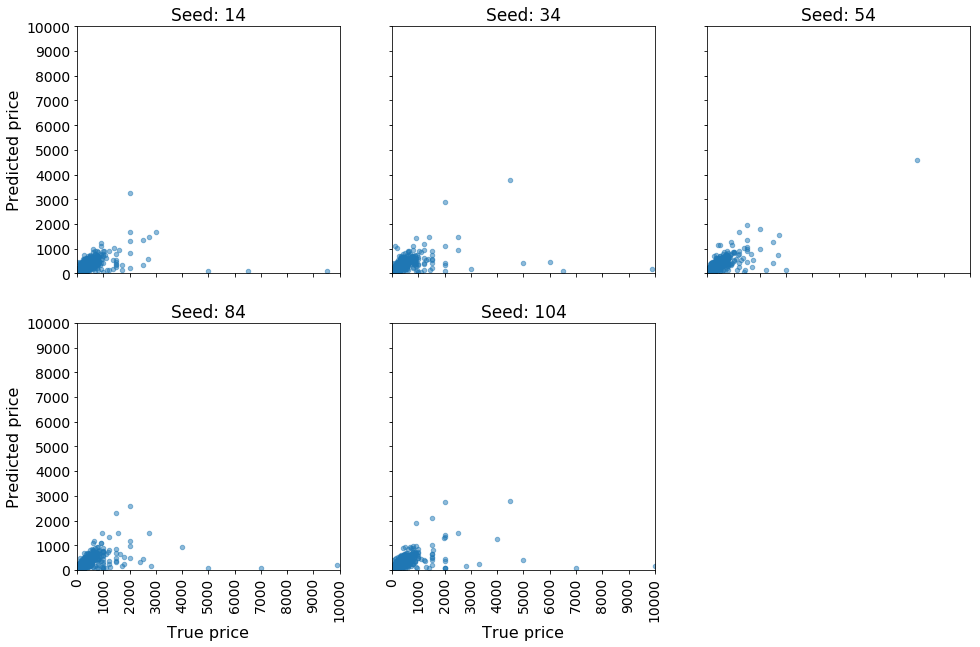

In [50]:
# Stratified sampling makes a whole lot of difference
# Oversampling the minority instances would probably reduce RMSE
f, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)

d = train.drop(["price", "logprice"], 1).select_dtypes(include=((
    "uint8", "float64", "int64", "int32", "bool", "float32"))).fillna(0).copy()

rmses = []
for seed in [14, 34, 54, 84, 104]:
    trX, tX, trY, tY = train_test_split(d, train["logprice"], test_size=.25, random_state=seed, stratify=train["pricecat"])
    lgb = lightgbm.LGBMRegressor(random_state=14, n_estimators=800, max_depth=14, subsample=.5).fit(trX, trY)
    print "R^2 score: %.2f" % r2_score(tY, lgb.predict(tX))
    pd.DataFrame({"True price": 10 ** tY, "Predicted price": 10 ** lgb.predict(tX)}).plot.scatter(
        x="True price", y = "Predicted price", yticks=range(0, 10001, 1000), xticks=range(0, 10001, 1000),
        xlim=(0, 10000), ylim=(0, 10000), alpha=.5, ax=axes[len(rmses) / 3][len(rmses) % 3], rot=90,
        title=("Seed: %d" % seed))
    rmses.append(mean_squared_error(10 ** tY, 10 ** lgb.predict(tX)) ** (1 / 2.))
    
    print "RMSE: %.2f\n" % rmses[-1]
    
print "Average RMSE: %.2f" % (sum(rmses) / 5.)
_ = axes[-1][-1].set_visible(False)

One noticeable trend in the above plots is that the RMSE tends to be higher when there are a greater number of outliers (true price >= 3000) to be predicted.

The plot _Seed: 54_ has only one example in the test set with a high true price (~\\$8000). The predicted value for that example is also high (~$5000). The model to which that plot corresponds has the lowest RMSE (99.5) of all five models.

In [51]:
lgb = lightgbm.LGBMRegressor(random_state=14, n_estimators=800, max_depth=14, subsample=.6).fit(d, train.logprice.values)

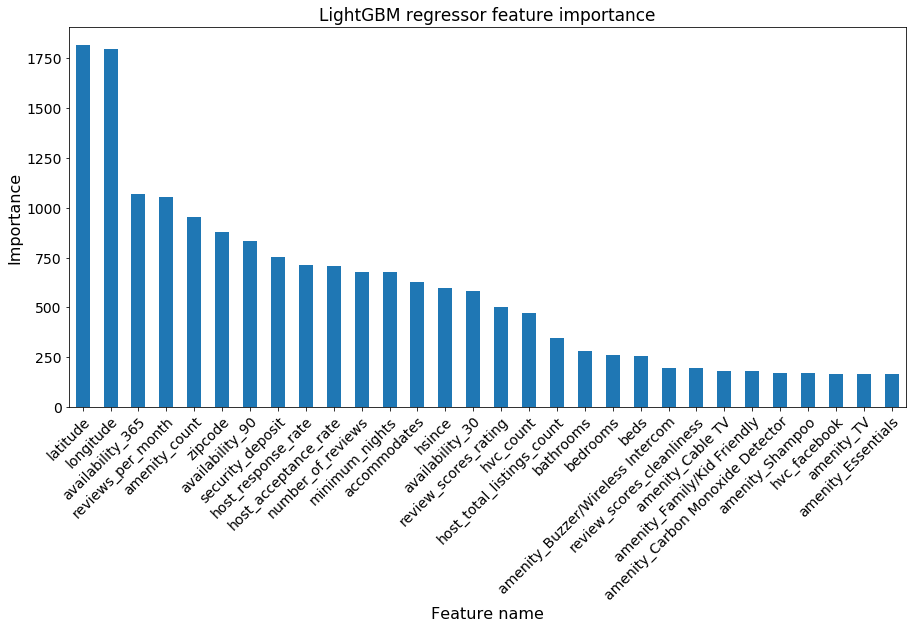

In [52]:
_ = pd.DataFrame({"c": trX.columns.tolist(), "i": lgb.feature_importances_})\
.sort_values("i", ascending=False).set_index("c")[:30].plot.bar(
    figsize=(15, 7), legend="").set(xlabel="Feature name", ylabel="Importance",
                                    title="LightGBM regressor feature importance"),\
plt.xticks(rotation=45, ha="right", rotation_mode="anchor"), collect()

In [53]:
test_df = test.select_dtypes(include=(("uint8", "float64", "int64", "int32", "bool", "float32"))).fillna(0).copy(deep=True)

#### Predictions on test data
[back to top](#Table-of-Contents)

In [ ]:
pd.DataFrame(index=test_df.index.values, data={"predicted_price": 10 ** lgb.predict(test_df)})

### Treating it as a classification problem
[back to top](#Table-of-Contents)

In [55]:
train.price.describe(percentiles=[.1,.25,.5,.75,.85, .9, .95, .99, .999])
train.loc[:, "pricecat"] = pd.cut(train.price, [0, 110, 220, 350, 700, 2000, 10000])

In [56]:
d = train.drop(["price", "logprice", "pricecat"], 1).select_dtypes(include=((
    "uint8", "float64", "int64", "int32", "bool", "float32"))).fillna(0).copy()

In [58]:
sss = SSS(n_splits=2, train_size=.8, random_state=54)
sss = list(sss.split(d, train[["pricecat"]]))
i = train.iloc[sss[0][0]].pricecat.apply(lambda x: str(x))

In [59]:
lgbmc = LGBMC(max_depth=11, n_estimators=300, class_weight="balanced", random_state=14)
lgbmc.fit(d.iloc[sss[0][0]], i)
print "Log loss: %.2f" % log_loss(train.pricecat[sss[0][1]].apply(lambda x: str(x)), lgbmc.predict_proba(d.loc[sss[0][1]]))
print "Accuracy: %.2f" % lgbmc.score(d.loc[sss[0][1]], train.pricecat[sss[0][1]].apply(lambda x: str(x)))

Log loss: 0.60
Accuracy: 0.76


In [60]:
xgbc = xgboost.XGBClassifier(max_depth=11, n_estimators=300, n_jobs=-1, random_state=14)
xgbc.fit(d.iloc[sss[0][0]], i)
print "Log loss: %.2f" % log_loss(train.pricecat[sss[0][1]].apply(lambda x: str(x)), xgbc.predict_proba(d.loc[sss[0][1]]))
print "Accuracy: %.2f" % xgbc.score(d.loc[sss[0][1]], train.pricecat[sss[0][1]].apply(lambda x: str(x)))

Log loss: 0.68
Accuracy: 0.77


In [61]:
lgbmc = LGBMC(max_depth=11, n_estimators=300, class_weight="balanced", random_state=14).fit(d, train.pricecat.apply(lambda x: str(x)).values)

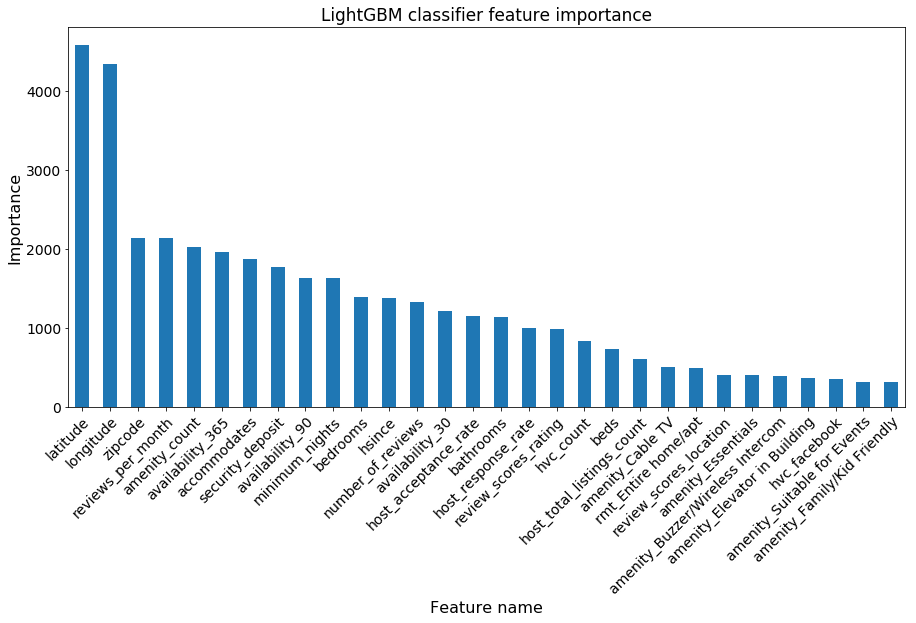

In [62]:
_ = pd.DataFrame({"c": d.columns.tolist(), "i": lgbmc.feature_importances_})\
.sort_values("i", ascending=False)\
.set_index("c")[:30].plot.bar(figsize=(15, 7), legend="").set(
    xlabel="Feature name", ylabel="Importance", title="LightGBM classifier feature importance"),\
plt.xticks(rotation=45, ha="right", rotation_mode="anchor"), collect()

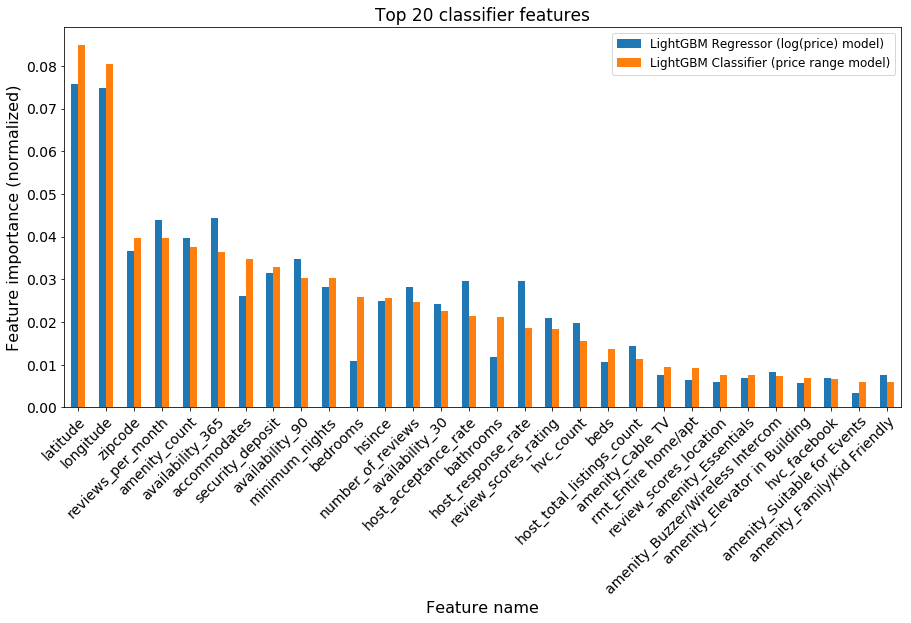

In [63]:
_ = pd.DataFrame({"c": trX.columns.tolist(), "LightGBM Regressor (log(price) model)": lgb.feature_importances_ / sum(lgb.feature_importances_.astype(float))}).merge(
pd.DataFrame({"c": d.columns.tolist(), "LightGBM Classifier (price range model)": lgbmc.feature_importances_ / sum(lgbmc.feature_importances_.astype(float))}), on="c")\
.set_index("c").sort_values("LightGBM Classifier (price range model)", ascending=False).iloc[:30].plot.bar(title="Top 20 classifier features", figsize=(15, 7)).set(xlabel="Feature name", ylabel="Feature importance (normalized)"),\
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

Both models give high importance to latitude, longitude, and zipcode features. It should also be noted that while some clusters of features have a significant correlation, they are not necessarily problematic for gradient boosted trees, which are more robust to collinearity.

#### Predictions on test data&nbsp;
[back to top](#Table-of-Contents)

In [ ]:
pd.DataFrame(index=test_df.index.values, data={"predicted_price_range": lgbmc.predict(test_df)})

<hr>

In [65]:
pd.DataFrame({"ep": extra_people, "gi": guests_included, "p": price, "acc": train.accommodates})\
.query("gi >= 0").corr("spearman")

,acc,ep,gi,p
acc,1.000000,0.231629,0.451079,0.555984
ep,0.231629,1.000000,0.535846,0.025057
gi,0.451079,0.535846,1.000000,0.294173
p,0.555984,0.025057,0.294173,1.000000


## Predicting `guests_included`
[back to top](#Table-of-Contents)

In [ ]:
guests_included.value_counts()

In [ ]:
guests_included.value_counts().apply(np.log10).sort_index().plot.bar(figsize=(15,8))

In [67]:
gi = guests_included.copy()
gi[gi >= 7] = 7

In [68]:
sss = SSS(n_splits=5, train_size=.8, random_state=54)
sss = list(sss.split(d, gi))

In [ ]:
# Balanced sample
# gi.to_frame().reset_index().groupby("guests_included").apply(lambda x: x.sample(n=80)).drop(["guests_included", "index"], 1)

Log-loss: 0.85
Accuracy: 0.68

Log-loss: 0.83
Accuracy: 0.67

Log-loss: 0.87
Accuracy: 0.67



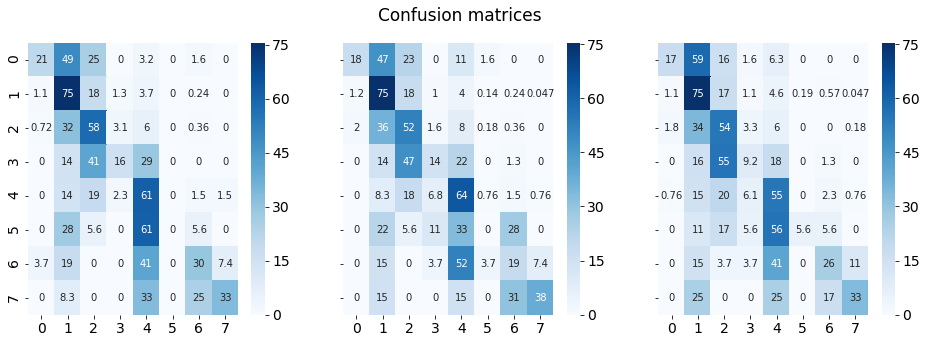

In [72]:
f, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
for x in range(3):
    lgbmc = LGBMC(max_depth=12, n_estimators=400, class_weight="balanced", random_state=14, colsample_bytree=.6)
    i = gi.iloc[sss[x][0]]
    lgbmc.fit(d.loc[sss[x][0]], i)
    print "Log-loss: %.2f" % log_loss(gi[sss[x][1]], lgbmc.predict_proba(d.loc[sss[x][1]]))
    print "Accuracy: %.2f\n" % lgbmc.score(d.loc[sss[x][1]], gi[sss[x][1]])
    c = confusion_matrix(gi[sss[x][1]], lgbmc.predict(d.loc[sss[x][1]]))
    c = (c * 100. / c.sum(axis=1).reshape(8,1))
    sns.heatmap(c, cmap="Blues", annot=True, ax=axes[x % 3])
_ = f.suptitle("Confusion matrices", fontsize=17.), collect()

Train on entire dataset.

In [73]:
lgbmc.fit(d, gi)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.6, importance_type='split', learning_rate=0.1,
        max_depth=12, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=400, n_jobs=-1, num_leaves=31,
        objective=None, random_state=14, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

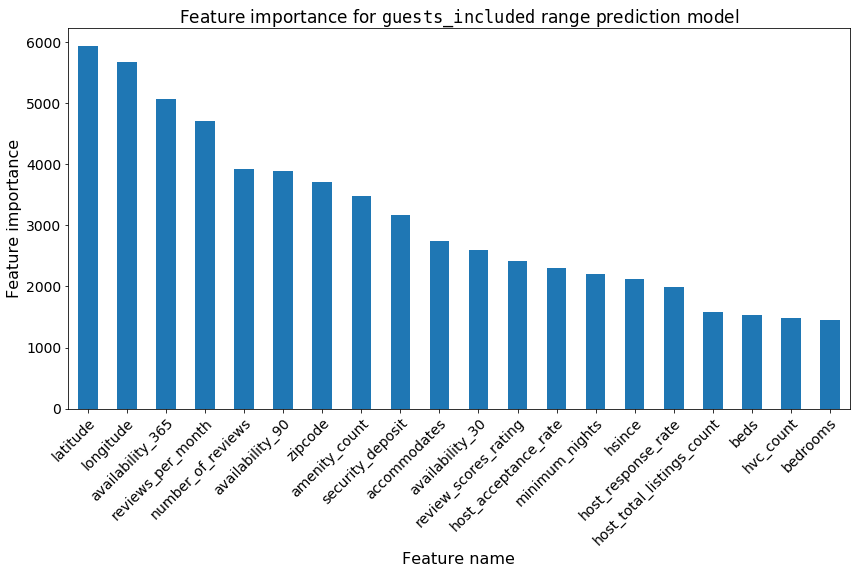

In [76]:
_ = pd.DataFrame({"c": d.columns.tolist(), "i": lgbmc.feature_importances_})\
.sort_values("i", ascending=False)\
.set_index("c")[:20].plot.bar(legend="", title="Feature importance for $\mathtt{guests\_included}$ range prediction model").set(xlabel="Feature name", ylabel="Feature importance"),\
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

#### Predicting on test data
[back to top](#Table-of-Contents)

In [ ]:
pd.DataFrame(index=test_df.index.values, data={"predicted_price_range": lgbmc.predict(test_df)})

## Predicting `extra_people`
[back to top](#Table-of-Contents)

In [77]:
extra_people.describe(percentiles=[0.05, 0.1, .25, .5, .55, .56, .75, .85, .9, .95, .99, .999]).to_frame().T

,count,mean,std,min,5%,10%,25%,50%,55.0%,56.0%,75%,85%,90%,95%,99%,99.9%,max
extra_people,30000.0,13.257833,22.070099,0.0,0.0,0.0,0.0,0.0,0.0,5.0,20.0,30.0,40.0,50.0,100.0,250.0,300.0


Over 50% of the hotels have extra people cost $0 (free).
We next investigate if price has a relation to extra people cost.

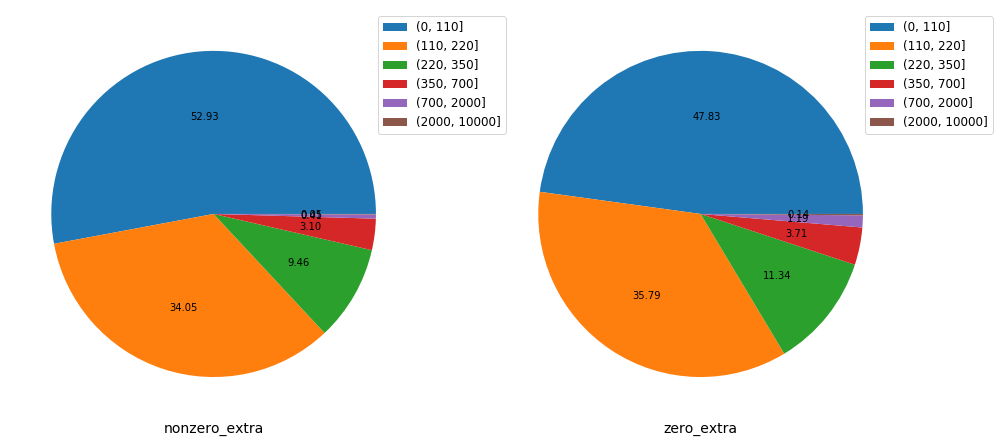

In [78]:
plotdf = pd.DataFrame({
    "zero_extra": train.pricecat[extra_people.where(extra_people==0.).dropna().index].value_counts(normalize=1),
    "nonzero_extra": train.pricecat[extra_people.where(extra_people>0.).dropna().index].value_counts(normalize=1)
})
for x in plotdf.plot.pie(subplots=True, figsize=(16, 7.5),autopct="%.2f", labels=None):
    x.legend(labels=plotdf.index.astype(str).values, loc=0, bbox_to_anchor=(0.89, 1))
    x.set_xlabel(x.get_ylabel(), size=14.)
    x.set_ylabel("")

We see above that price indeed has a small but noticeable relation with extra people cost.

Of the places that have a non-zero extra people cost, over 50% are places that have a daily rental of or under $110. A cautious interpretation of this could be that places that charge less daily rent do not allow extra people for free.

Conversely, of the places with zero extra people cost, over 50% are places that have a daily rental over $110.

### Binary classification approach
[back to top](#Table-of-Contents)

In [79]:
gi = extra_people == 0

In [80]:
sss = SSS(n_splits=2, train_size=.8, random_state=54)
sss = list(sss.split(d, gi))
i = gi.iloc[sss[0][0]]

In [81]:
lgbmc = LGBMC(max_depth=12, n_estimators=200, class_weight="balanced", random_state=14, colsample_bytree=.6)
lgbmc.fit(d.iloc[sss[0][0]], i)
print "Log loss: %.2f" % log_loss(gi[sss[0][1]], lgbmc.predict_proba(d.loc[sss[0][1]]))
print "Accuracy: %.2f" % lgbmc.score(d.loc[sss[0][1]], gi[sss[0][1]])

Log loss: 0.55
Accuracy: 0.73


In [82]:
xgbmc = xgboost.XGBClassifier(max_depth=12, n_estimators=200, class_weight="balanced", random_state=14, colsample_bytree=.6)
xgbmc.fit(d.iloc[sss[0][0]], i)
print "Log loss: %.2f" % log_loss(gi[sss[0][1]], xgbmc.predict_proba(d.loc[sss[0][1]]))
print "Accuracy: %.2f" % xgbmc.score(d.loc[sss[0][1]], gi[sss[0][1]])

Log loss: 0.57
Accuracy: 0.71


In [83]:
c = confusion_matrix(gi[sss[0][1]], lgbmc.predict(d.loc[sss[0][1]]))
print c

[[ 947  394]
 [ 426 1233]]


In [84]:
xgb_preds = xgbmc.predict(d.loc[sss[0][1]])
lgb_preds = lgbmc.predict(d.loc[sss[0][1]])

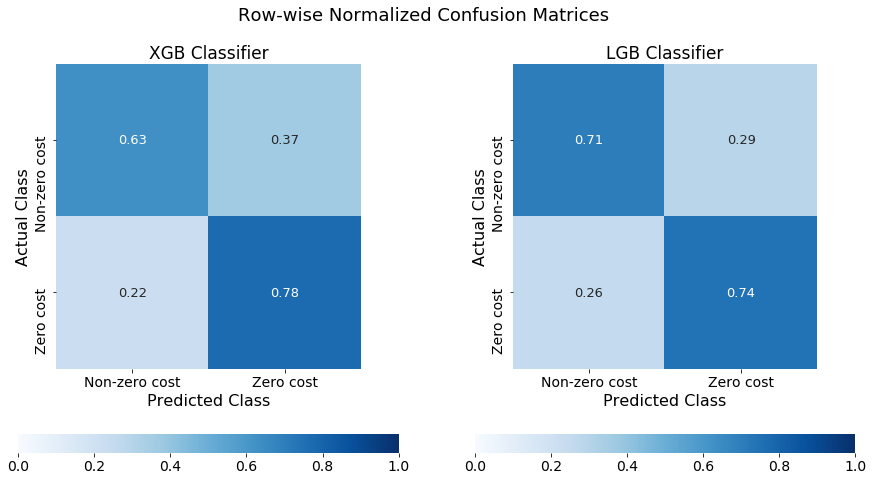

In [85]:
f, ax = plt.subplots(1, 2, figsize = (15, 8))
f.suptitle("Row-wise Normalized Confusion Matrices", fontsize = 18.)
def make_cm(cm, t, axis):
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square=True, xticklabels=["Non-zero cost", "Zero cost"], vmin=0, vmax=1, annot=True,
                    annot_kws={"fontsize": 13}, yticklabels=["Non-zero cost", "Zero cost"],
                    cbar=True, cbar_kws={"orientation": "horizontal"}, ax=ax[axis], cmap="Blues").set(
        xlabel="Predicted Class", ylabel="Actual Class", title=t), collect()
make_cm(confusion_matrix(gi[sss[0][1]], xgb_preds), "XGB Classifier", 0)
make_cm(confusion_matrix(gi[sss[0][1]], lgb_preds), "LGB Classifier", 1)

In [86]:
print "XGB Classifier Performance\n" + "=" * 26 + "\n",\
classification_report(gi[sss[0][1]], xgb_preds, target_names=["Non-zero cost", "Zero cost"])
print("AUC      : %.4f" % roc_auc_score(gi[sss[0][1]], xgb_preds))
print("Accuracy : %.4f" % accuracy_score(gi[sss[0][1]], xgb_preds))
print("Log Loss : %.4f\n\n" % log_loss(gi[sss[0][1]], xgbmc.predict_proba(d.loc[sss[0][1]])))
print "LGB Classifier Performance\n" + "=" * 26 + "\n",\
classification_report(gi[sss[0][1]], lgb_preds, target_names=["Non-zero cost", "Zero cost"])
print("AUC      : %.4f" % roc_auc_score(gi[sss[0][1]], lgb_preds))
print("Accuracy : %.4f" % accuracy_score(gi[sss[0][1]], lgb_preds))
print("Log Loss : %.4f\n\n" % log_loss(gi[sss[0][1]], lgbmc.predict_proba(d.loc[sss[0][1]])))

XGB Classifier Performance
               precision    recall  f1-score   support

Non-zero cost       0.69      0.63      0.66      1341
    Zero cost       0.72      0.78      0.75      1659

    micro avg       0.71      0.71      0.71      3000
    macro avg       0.71      0.70      0.70      3000
 weighted avg       0.71      0.71      0.71      3000

AUC      : 0.7034
Accuracy : 0.7110
Log Loss : 0.5743


LGB Classifier Performance
               precision    recall  f1-score   support

Non-zero cost       0.69      0.71      0.70      1341
    Zero cost       0.76      0.74      0.75      1659

    micro avg       0.73      0.73      0.73      3000
    macro avg       0.72      0.72      0.72      3000
 weighted avg       0.73      0.73      0.73      3000

AUC      : 0.7247
Accuracy : 0.7267
Log Loss : 0.5455




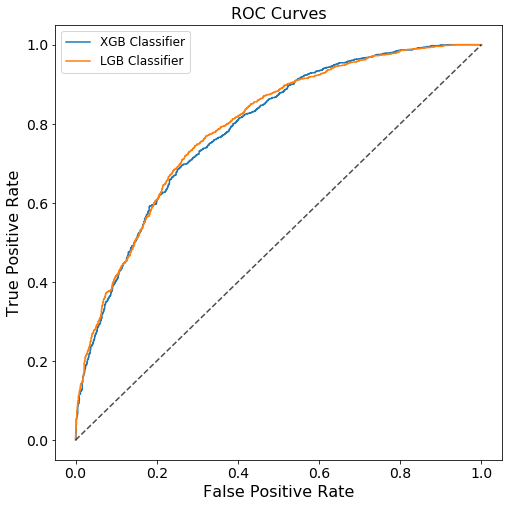

In [87]:
_ = plt.figure(figsize = (8, 8)), plt.plot(*roc_curve(gi[sss[0][1]], xgbmc.predict_proba(d.loc[sss[0][1]]).T[1])[:2]), plt.plot(*roc_curve(gi[sss[0][1]], lgbmc.predict_proba(d.loc[sss[0][1]]).T[1])[:2], c = sns.color_palette()[1]), plt.legend(["XGB Classifier", "LGB Classifier"], loc = "upper left")
_ = plt.plot((0., 1.), (0., 1.), "--k", alpha = .7), plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)

<hr>

In [ ]:
lgbmc.fit(d, gi)

#### Predicting on test data
[back to top](#Table-of-Contents)

In [ ]:
pd.DataFrame(index=test_df.index.values, data={"predicted_price_range": lgbmc.predict(test_df)})

### Multi-class classification approach
[back to top](#Table-of-Contents)

In [89]:
extra_people.describe(percentiles=[0.05, 0.1, .25, .5, .55, .56, .75, .85, .9, .95, .99, .999]).to_frame().T

,count,mean,std,min,5%,10%,25%,50%,55.0%,56.0%,75%,85%,90%,95%,99%,99.9%,max
extra_people,30000.0,13.257833,22.070099,0.0,0.0,0.0,0.0,0.0,0.0,5.0,20.0,30.0,40.0,50.0,100.0,250.0,300.0


It makes sense to define extra cost ranges based on the above distribution. Common sense dictates that our bins be defined as
- _no cost_
- \\$4 to \\$50 (lower range)
- \\$51 to \\$100 (middle range)
- \\$101 to \\$300 (higher range)


In [90]:
gi = pd.cut(extra_people, [0, 4, 50, 100, 300],).astype(str).str.replace("nan", "no cost")

In [91]:
sss = SSS(n_splits=2, train_size=.8, random_state=54)
sss = list(sss.split(d, gi))

In [92]:
for x in range(2):
    i = gi[sss[x][0]]
    lgbmc = LGBMC(max_depth=12, n_estimators=400, class_weight="balanced", random_state=14,)
    lgbmc.fit(d.loc[sss[x][0]], i)
    print classification_report(gi[sss[x][1]], lgbmc.predict(d.loc[sss[x][1]]))
    print "Log loss: %.2f" % log_loss(gi[sss[x][1]], lgbmc.predict_proba(d.loc[sss[x][1]]))
    print "Accuracy: %.2f\n" % lgbmc.score(d.loc[sss[x][1]], gi[sss[x][1]])

              precision    recall  f1-score   support

  (100, 300]       1.00      0.08      0.15        12
     (4, 50]       0.66      0.66      0.66      1254
   (50, 100]       0.18      0.13      0.15        75
     no cost       0.74      0.75      0.74      1659

   micro avg       0.69      0.69      0.69      3000
   macro avg       0.64      0.41      0.43      3000
weighted avg       0.69      0.69      0.69      3000

Log loss: 0.70
Accuracy: 0.69

              precision    recall  f1-score   support

  (100, 300]       0.00      0.00      0.00        12
     (4, 50]       0.65      0.69      0.67      1254
   (50, 100]       0.10      0.07      0.08        75
     no cost       0.75      0.73      0.74      1659

   micro avg       0.69      0.69      0.69      3000
   macro avg       0.37      0.37      0.37      3000
weighted avg       0.69      0.69      0.69      3000

Log loss: 0.70
Accuracy: 0.69



In [93]:
lgbmc.fit(d, gi)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=12, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=400, n_jobs=-1, num_leaves=31,
        objective=None, random_state=14, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

<hr>

# Future work
[Back to top](#Table-of-Contents)

- **More EDA!**: This is the most crucial step as it helps, at least partially, to establish a baseline expectation for how well a predictive model would perform on the given data. Every model has a certain amount of irreducible error and while EDA is not a rigorous way to estimate it, it surely gives us a rudimentary idea.


- *Bias-variance analysis*: Among other things, we would look at the learning and validation curves. This helps us understand if adding more data would benefit the model.


- *Treatement of missing data*: Use smarter imputation for null values and reducing the number of trial-and-error iterations using a combination of common sense and domain knowledge. There are various methods to try. Some are domain-specific or non-technical such as obtaining it from the client or a subject matter expert, while others are independent such as mean/median imputation and groupby-based aggregates. We could use examine grouped aggregates to check if there's a trend and impute nulls accordingly. E.g. we could calculate a central tendency measure such as mean/median for `security_deposit` group-wise using `room_type` or `property_type` as the column to group by. We could also predict values in certain columns using machine learning models built with other columns.


- *Correlated features*: Combine or remove more highly correlated columns.


- *Stage-wise models*: Two-stage or n-stage models where we first predict the price class or class of the extra cost or class of guests included and then use regression sub-models to predict the actual guest count or price or extra cost.


- *Outlier treatment*: Remove outliers based on QQ plot of price and log(price).


- *Ensembles*:
    - A stacked ensemble would significantly improve model performance. We take an n-fold train-test split with a completely separate holdout validation set.
      1. We train various models (decision trees, gradient boosting machines, SVMs, linear/logistic regression, random forests, kNN, and so on) on the same training set.
      2. We generate predictions on the test set using each of these models.
      3. We train a second model—a "stacker"—that takes these predictions as features and the true labels of the test set as the output.
      4. This way the second models figures out the best way to combine or use the predictions generated from various models.
    - A simple weighted ensemble would also be worth a try. Herein, we manually do a weighted average of predictions generated from various models.


- *Feature selection*: Since there are a lot of features with low importance as indicated from feature importance plot, we should definitely try forward selection and/or backward elimination to reduce feature space. We could automatically "elimiate" unimportant features to some extent by setting stricter L1 regularization.


- *Grid search*: We have not performed any grid search. That is definitely something worth doing in order to find the best hyperparameters for a model.


- *Step-wise prediction*: Predict price bracket, then predict `guests_included`, and so on.


- *Top n features*: Use top _n_ features based on feature importance plot.


- *Sampling*: 
    - Balanced stratified samples (i.e. *s* each from each class)
    - Use SMOTE for oversampling minority classes


- *Other models*: We have only tried using gradient boosted decision trees in this analysis. In the future, we should use other models as well. A stacked ensemble of diverse models can give very good predictions.


- *Partial dependence plots*: These help us identify the impact of individual features and verify that it meshes with our intuition.

<hr>

# References

http://insideairbnb.com/get-the-data.html <br>
https://towardsdatascience.com/uncovering-the-secrets-to-higher-airbnb-revenues-6dbf178942af